# News summarization using transformers

# Model 1: LTSM Model

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
import gradio as gr
from transformers import BartForConditionalGeneration, BartTokenizer
import torch
import gradio as gr
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

In [1]:

# Load the dataset
file_path = 'CNNnews2.csv'  # Replace with the correct path to your file
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
display(data.head())



First few rows of the dataset:


,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


In [2]:

# Display basic information about the dataset
print("\nDataset Info:")
data.info()



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          249 non-null    object
 1   article     249 non-null    object
 2   highlights  249 non-null    object
dtypes: object(3)
memory usage: 6.0+ KB


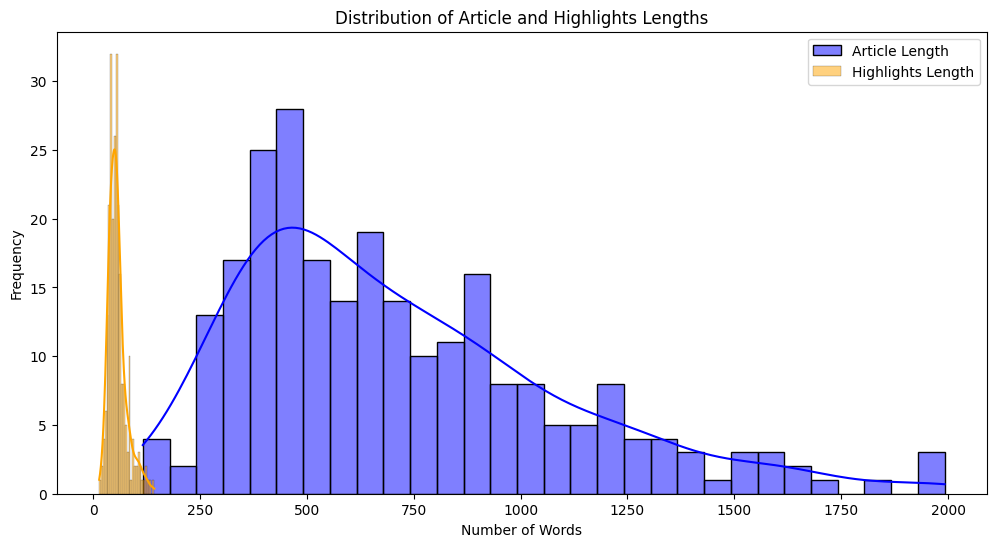

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


# Article length distribution
data['article_length'] = data['article'].apply(lambda x: len(word_tokenize(x)))
data['highlights_length'] = data['highlights'].apply(lambda x: len(word_tokenize(x)))

# Plot article and highlight length distributions
plt.figure(figsize=(12, 6))
sns.histplot(data['article_length'], kde=True, color='blue', bins=30, label='Article Length')
sns.histplot(data['highlights_length'], kde=True, color='orange', bins=30, label='Highlights Length')
plt.legend()
plt.title('Distribution of Article and Highlights Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()




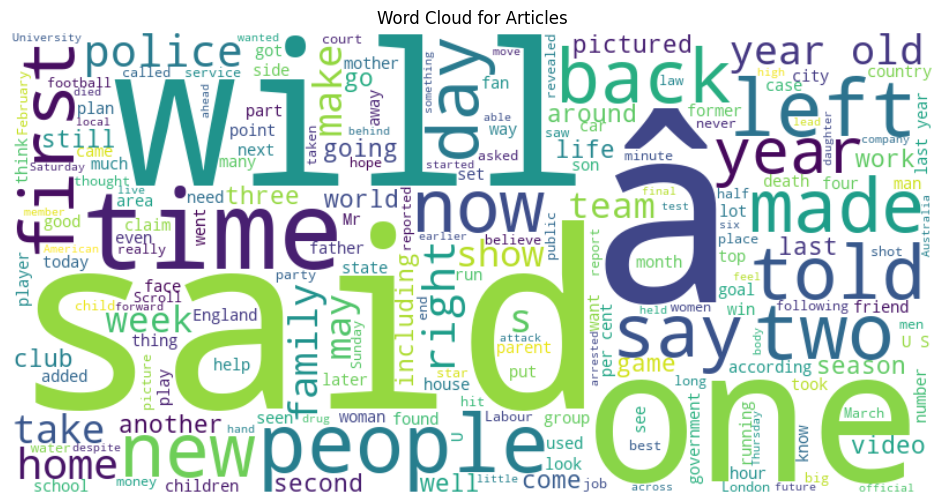

In [4]:
# Generate a word cloud for articles
article_text = " ".join(data['article'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(article_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Articles')
plt.show()


In [5]:

# Check most frequent words in highlights
highlight_text = " ".join(data['highlights'].tolist())
highlight_tokens = word_tokenize(highlight_text)
highlight_vocab = pd.Series(highlight_tokens).value_counts().head(20)

print("\nMost Frequent Words in Highlights:")
print(highlight_vocab)



Most Frequent Words in Highlights:
.       892
the     418
,       344
to      319
in      259
and     238
of      235
a       234
on      149
for     144
was     119
his     109
with    108
's       97
is       97
'        95
The      92
at       90
has      88
from     87
Name: count, dtype: int64


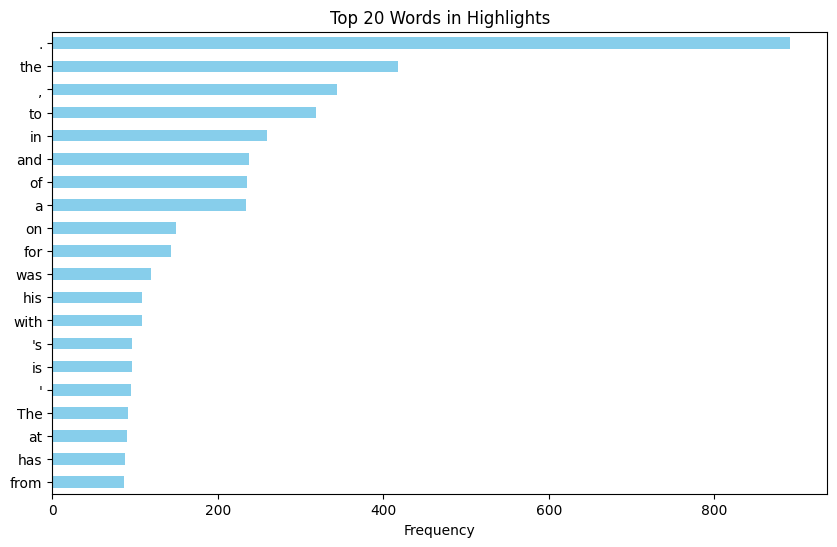

In [6]:

# Plot the top words
highlight_vocab.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 20 Words in Highlights')
plt.xlabel('Frequency')
plt.show()

In [7]:

# Preprocess text (Tokenization)
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return tokens

# Tokenize articles and highlights
data['tokenized_article'] = data['article'].apply(preprocess_text)
data['tokenized_highlights'] = data['highlights'].apply(preprocess_text)

# Build a vocabulary
all_tokens = [token for article in data['tokenized_article'] for token in article]
vocab = Counter(all_tokens)
vocab = {word: idx+1 for idx, (word, _) in enumerate(vocab.items())}  # Reserve 0 for padding

# Encode tokens
def encode_text(tokens, vocab):
    return [vocab.get(token, 0) for token in tokens]

data['encoded_article'] = data['tokenized_article'].apply(lambda x: encode_text(x, vocab))
data['encoded_highlights'] = data['tokenized_highlights'].apply(lambda x: encode_text(x, vocab))

# Pad sequences
def pad_sequences(sequences, max_len):
    return [seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences]

MAX_LEN_ARTICLE = 500
MAX_LEN_HIGHLIGHTS = 50

data['padded_article'] = pad_sequences(data['encoded_article'], MAX_LEN_ARTICLE)
data['padded_highlights'] = pad_sequences(data['encoded_highlights'], MAX_LEN_HIGHLIGHTS)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    np.array(data['padded_article'].tolist()),
    np.array(data['padded_highlights'].tolist()),
    test_size=0.2,
    random_state=42
)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MAPILI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class NewsSummaryDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

train_dataset = NewsSummaryDataset(X_train, y_train)
test_dataset = NewsSummaryDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [9]:
import torch.nn as nn

class LSTMNewsSummarizer(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1):
        super(LSTMNewsSummarizer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out)
        return output


In [20]:
import torch
import torch.nn as nn

# Hyperparameters
VOCAB_SIZE = len(vocab) + 1
EMBED_SIZE = 128
HIDDEN_SIZE = 256
OUTPUT_SIZE = VOCAB_SIZE
NUM_LAYERS = 1
EPOCHS = 10
LR = 0.001

# Initialize model
model = LSTMNewsSummarizer(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for articles, highlights in train_loader:
        articles, highlights = articles.to(device), highlights.to(device)

        # Shift highlights for teacher forcing
        inputs, targets = highlights[:, :-1], highlights[:, 1:]

        optimizer.zero_grad()

        # Model forward pass
        outputs = model(articles)

        # Adjust outputs to match target sequence length
        outputs = outputs[:, :targets.size(1), :]  # Keep only the relevant outputs

        # Reshape outputs to (batch_size * seq_len, vocab_size)
        outputs = outputs.reshape(-1, VOCAB_SIZE)

        # Flatten targets to (batch_size * seq_len)
        targets = targets.contiguous().reshape(-1)

        # Compute loss
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1, Loss: 9.7271
Epoch 2, Loss: 9.6146
Epoch 3, Loss: 9.2473
Epoch 4, Loss: 8.0512
Epoch 5, Loss: 7.1776
Epoch 6, Loss: 6.9047
Epoch 7, Loss: 6.8226
Epoch 8, Loss: 6.9063
Epoch 9, Loss: 6.8043
Epoch 10, Loss: 6.7508


In [21]:
model.eval()
with torch.no_grad():
    for articles, highlights in test_loader:
        articles, highlights = articles.to(device), highlights.to(device)
        outputs = model(articles)

        # Decoding output (greedy decoding)
        predicted_summary = outputs.argmax(dim=-1)
        print(f"Predicted: {predicted_summary[0]}")
        print(f"Target: {highlights[0]}")
        break


Predicted: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 3

In [26]:
import torch
from nltk.tokenize import word_tokenize

# Ensure <UNK> token is in the vocabulary
if '<UNK>' not in vocab:
    vocab['<UNK>'] = len(vocab)  # Assign a new index for <UNK>

# Function to preprocess and encode text
def preprocess_and_encode(text, vocab, max_len):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    # If token is not in vocab, use <UNK> index
    encoded_text = [vocab.get(token, vocab['<UNK>']) for token in tokens]  # Map tokens to indices using vocab
    padded_text = encoded_text[:max_len] + [0] * (max_len - len(encoded_text))  # Pad to max_len
    return padded_text

# Function to decode the output sequence into text (converting indices to words)
def decode_summary(output_indices, vocab_inv):
    decoded_text = [vocab_inv.get(idx, '<UNK>') for idx in output_indices if idx != 0]  # Exclude padding (0)
    return ' '.join(decoded_text)

# Create an inverse vocabulary (index to word mapping)
vocab_inv = {idx: word for word, idx in vocab.items()}

# Sample real text for evaluation
sample_article = """
In the recent scientific breakthroughs, quantum computing has become one of the most promising fields of research. 
With the potential to revolutionize various industries such as cryptography, healthcare, and artificial intelligence, 
quantum computers could dramatically speed up problem-solving processes by harnessing the principles of quantum mechanics.
"""

# Preprocess and encode the article
encoded_article = preprocess_and_encode(sample_article, vocab, MAX_LEN_ARTICLE)
encoded_article_tensor = torch.tensor([encoded_article], dtype=torch.long).to(device)

# Evaluate the model
model.eval()
with torch.no_grad():
    # Get the model output
    outputs = model(encoded_article_tensor)

    # Decoding the predicted summary (using greedy decoding)
    predicted_summary_indices = outputs.argmax(dim=-1).cpu().numpy()[0]  # Get the predicted indices for the summary

    
    # Decode the indices to words (summary)
    predicted_summary = decode_summary(predicted_summary_indices, vocab_inv)

    print("Predicted Summary:")
    print(predicted_summary)


Predicted Summary:
in . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

# Model 2;bart-large-cnn

In [29]:
from transformers import BartForConditionalGeneration, BartTokenizer
import torch

# Load the pretrained BART model and tokenizer
model_name = "facebook/bart-large-cnn"
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Function to summarize an article using BART
def summarize_article(article_text):
    inputs = tokenizer([article_text], max_length=1024, return_tensors="pt", truncation=True, padding="longest").to(device)
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=30, max_length=150, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Sample article text
sample_article = """
In the recent scientific breakthroughs, quantum computing has become one of the most promising fields of research. 
With the potential to revolutionize various industries such as cryptography, healthcare, and artificial intelligence, 
quantum computers could dramatically speed up problem-solving processes by harnessing the principles of quantum mechanics.
"""

# Get the summary
summary = summarize_article(sample_article)

# Print the summary
print("Predicted Summary:")
print(summary)


Predicted Summary:
Quantum computing has become one of the most promising fields of research. It has the potential to revolutionize various industries such as cryptography, healthcare, and artificial intelligence.


In [33]:

# Load the pretrained BART model and tokenizer
model_name = "facebook/bart-large-cnn"
model = BartForConditionalGeneration.from_pretrained(model_name)
tokenizer = BartTokenizer.from_pretrained(model_name)

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Function to summarize an article using BART
def summarize_article(article_text):
    # Tokenize the article input
    inputs = tokenizer([article_text], max_length=1024, return_tensors="pt", truncation=True, padding="longest").to(device)
    
    # Generate the summary
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=30, max_length=150, early_stopping=True)
    
    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Gradio interface function
def summarize_input(text):
    return summarize_article(text)

# Create Gradio interface for input and output
iface = gr.Interface(
    fn=summarize_input,  # Function to summarize the input text
    inputs="text",  # User input is text
    outputs="text",  # Output is also text (summarized article)
    title="News Summarizer",  # Title of the interface
    description="Enter an article, and the model will generate a summary for it.",  # Description of the interface
)

# Launch the Gradio interface
iface.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.26.0, however version 4.44.1 is available, please upgrade.
--------


# Model 3: Pretrained T5 Model for Summarization

In [35]:


# Load the pretrained T5 model and tokenizer
model_name = "t5-large"  # You can also use "t5-base" if "t5-large" is too large for your environment
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Function to summarize an article using T5
def summarize_article(article_text):
    # Prefix for T5 model summarization task
    input_text = "summarize: " + article_text
    
    # Tokenize the article input
    inputs = tokenizer([input_text], max_length=1024, return_tensors="pt", truncation=True, padding="longest").to(device)
    
    # Generate the summary
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=30, max_length=150, early_stopping=True)
    
    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Gradio interface function
def summarize_input(text):
    return summarize_article(text)

iface = gr.Interface(
    fn=summarize_input,  # Function to summarize the input text
    inputs="text",  # User input is text
    outputs="text",  # Output is also text (summarized article)
    title="Article Summarizer with T5",  # Title of the interface
    description="Enter an article, and the T5 model will generate a summary for it.",  # Description of the interface
)

# Launch the Gradio interface
iface.launch()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Running on local URL:  http://127.0.0.1:7863
IMPORTANT: You are using gradio version 4.26.0, however version 4.44.1 is available, please upgrade.
--------

To create a public link, set `share=True` in `launch()`.
